# ACCIDENT DATA ANALYSIS

In [1]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
from sklearn.cluster import KMeans
import folium
from folium.plugins import MarkerCluster
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
## Establish a connection to the SQLite database 'accident_data_v1.0.0_2023.db'to interact with the database and query its contents.
con = sqlite3.connect("accident_data_v1.0.0_2023.db")

In [3]:
#In order to execute SQL statements and fetch results from SQL queries, use a database cursor.
cur = con.cursor()

In [4]:
# Query the database to retrieve a list of all table names in the SQLite database.
# The 'sqlite_master' table contains metadata about the database structure.
# The result is ordered by table name and then fetched as a list of all table names.
table_list=cur.execute("SELECT name FROM sqlite_master WHERE type= 'table' ORDER BY name;")
table_list.fetchall()

[('accident',), ('casualty',), ('lsoa',), ('vehicle',)]

In [5]:
#create a list of tables
tables = ['accident', 'casualty', 'vehicle', 'lsoa']

In [6]:
# Function to print columns of a table
def print_table_columns(table_name):
    col_info = cur.execute(f"PRAGMA table_info({table_name})")
    columns = col_info.fetchall()
    print(f"Columns in {table_name} table:")
    for col in columns:
        print(col[1], end=', ')  # Printing the column name seperated by comma and space
    print( ) #print a space before the columns of a new table"
# Iterate over tables and print columns
for table in tables:
    print_table_columns(table )

Columns in accident table:
accident_index, accident_year, accident_reference, location_easting_osgr, location_northing_osgr, longitude, latitude, police_force, accident_severity, number_of_vehicles, number_of_casualties, date, day_of_week, time, local_authority_district, local_authority_ons_district, local_authority_highway, first_road_class, first_road_number, road_type, speed_limit, junction_detail, junction_control, second_road_class, second_road_number, pedestrian_crossing_human_control, pedestrian_crossing_physical_facilities, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site, carriageway_hazards, urban_or_rural_area, did_police_officer_attend_scene_of_accident, trunk_road_flag, lsoa_of_accident_location, 
Columns in casualty table:
casualty_index, accident_index, accident_year, accident_reference, vehicle_reference, casualty_reference, casualty_class, sex_of_casualty, age_of_casualty, age_band_of_casualty, casualty_severity, pedestrian_loca

In [7]:
#filter the table for accidents in 2020
accident_df=pd.read_sql_query("SELECT* FROM ACCIDENT WHERE accident_year= 2020", con=con)

#join all the tables, filtering for 2020 accident year
joined_df = pd.read_sql_query("""
    SELECT *
    FROM accident
    LEFT JOIN vehicle ON accident.accident_index = vehicle.accident_index
    LEFT JOIN casualty ON accident.accident_index = casualty.accident_index
    LEFT JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
    WHERE accident.accident_year = 2020 
""", con=con)


In [8]:
# #drop duplicate column in dataframe
# joined_df=joined_df.T.drop_duplicates().T

In [9]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 90 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               220435 non-null  object 
 1   accident_year                                220435 non-null  int64  
 2   accident_reference                           220435 non-null  object 
 3   location_easting_osgr                        220401 non-null  float64
 4   location_northing_osgr                       220401 non-null  float64
 5   longitude                                    220401 non-null  float64
 6   latitude                                     220401 non-null  float64
 7   police_force                                 220435 non-null  int64  
 8   accident_severity                            220435 non-null  int64  
 9   number_of_vehicles                           220435 non-nul

In [10]:
# Check for missing (null) values in each column of the 'joined_df' DataFrame.
# The 'isnull()' function identifies missing values, and 'sum()' provides the total count of missing values per column.
joined_df.isnull().sum()

accident_index                0
accident_year                 0
accident_reference            0
location_easting_osgr        34
location_northing_osgr       34
                          ...  
lsoa01nm                  18492
lsoa01nmw                 18492
shape__area               18492
shape__length             18492
globalid                  18492
Length: 90, dtype: int64

In [11]:
# Check for duplicate rows
duplicate_rows = joined_df[joined_df.duplicated()]

# Print the duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [accident_index, accident_year, accident_reference, location_easting_osgr, location_northing_osgr, longitude, latitude, police_force, accident_severity, number_of_vehicles, number_of_casualties, date, day_of_week, time, local_authority_district, local_authority_ons_district, local_authority_highway, first_road_class, first_road_number, road_type, speed_limit, junction_detail, junction_control, second_road_class, second_road_number, pedestrian_crossing_human_control, pedestrian_crossing_physical_facilities, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site, carriageway_hazards, urban_or_rural_area, did_police_officer_attend_scene_of_accident, trunk_road_flag, lsoa_of_accident_location, vehicle_index, accident_index, accident_year, accident_reference, vehicle_reference, vehicle_type, towing_and_articulation, vehicle_manoeuvre, vehicle_direction_from, vehicle_direction_to, vehicle_location_restricted_lane, junction_location,

In [12]:
import pandas as pd

# Initialize an empty list to store the results
results = []

# Iterate over each column in the DataFrame
for col in joined_df.columns:
    # Count the occurrences of -1 values in the column
    count = (joined_df[col] == -1).sum()
    # Check if there are any -1 values in the column
    if count.any():
        # Append the column name and count to the results list
        results.append({'Column': col, 'Count_of_-1': count.item()})

# Create a DataFrame from the results list
result_df = pd.DataFrame(results)

# Print the resulting DataFrame
print(result_df)


                                         Column  Count_of_-1
0                      local_authority_district         2345
1                                   speed_limit           14
2                               junction_detail            4
3                              junction_control        93721
4                             second_road_class          281
5                            second_road_number        93118
6             pedestrian_crossing_human_control          321
7       pedestrian_crossing_physical_facilities          314
8                              light_conditions            1
9                            weather_conditions            1
10                      road_surface_conditions          666
11                   special_conditions_at_site          488
12                          carriageway_hazards          469
13  did_police_officer_attend_scene_of_accident            1
14                              trunk_road_flag        15810
15                      

# Data Cleaning

**local_authority_district**

In [13]:
# Access the 'local_authority_district' column from the 'joined_df' DataFrame.
# This column likely contains information about the local authority district for each record in the DataFrame.
joined_df['local_authority_district']

0          10
1           9
2           9
3           1
4          17
         ... 
220430    910
220431    910
220432    932
220433    932
220434    916
Name: local_authority_district, Length: 220435, dtype: int64

In [14]:
#relevant columns
#joined_df['day_of_week']
#joined_df['time']
#joined_df['vehicle_type']
#joied_df['casualty_class']
#joined_df['accident_severity']
#joined_df['weather_conditions']
#joined_df['road_surface_conditions']
#joined_df['light_conditions']
#joined_df['junction_detail']
#joined_df['urban_or_rural_area']
#joined_df['local_authority_ons_district']
#joined_df['casualty_severity']
#joined_df['speed_limit']
#joined_df['age_of_driver']
#joined_df['local_authority_ons_district']
#joined_df['casualty_severity']
#joined_df['speed_limit']
#joined_df['engine_capacity']
#joined_df['road_type']
#joined_df['age_of_driver']
#joined_df['sex_of_driver']
#joined_df['sex_of_casualty']

In [15]:
#list relevant columns in the analysis
relevant_columns = [
    'day_of_week', 
    'time', 
    'vehicle_type', 
    'casualty_class', 
    'accident_severity', 
    'weather_conditions', 
    'road_surface_conditions', 
    'light_conditions', 
    'junction_detail', 
    'urban_or_rural_area', 
    'local_authority_ons_district', 
    'casualty_severity', 
    'speed_limit', 
    'age_of_driver', 
    'engine_capacity_cc', 
    'road_type', 
    'sex_of_driver', 
    'sex_of_casualty',
    'age_of_casualty'
]


In [16]:
# Check for missing values in specific columns of the 'joined_df' DataFrame.
# 'relevant_columns' is a list or selection of columns to check for missing values.
missing_values = joined_df[relevant_columns].isnull().sum()
print(missing_values)

day_of_week                     0
time                            0
vehicle_type                    0
casualty_class                  0
accident_severity               0
weather_conditions              0
road_surface_conditions         0
light_conditions                0
junction_detail                 0
urban_or_rural_area             0
local_authority_ons_district    0
casualty_severity               0
speed_limit                     0
age_of_driver                   0
engine_capacity_cc              0
road_type                       0
sex_of_driver                   0
sex_of_casualty                 0
age_of_casualty                 0
dtype: int64


In [17]:
# Check for occurrences of the value -1 in the specified 'relevant_columns' of the 'joined_df' DataFrame.
missing_values_count = joined_df[relevant_columns].eq(-1).sum()
print(missing_values_count)

day_of_week                         0
time                                0
vehicle_type                        0
casualty_class                      0
accident_severity                   0
weather_conditions                  1
road_surface_conditions           666
light_conditions                    1
junction_detail                     4
urban_or_rural_area                 0
local_authority_ons_district        0
casualty_severity                   0
speed_limit                        14
age_of_driver                   27373
engine_capacity_cc              51172
road_type                           0
sex_of_driver                      15
sex_of_casualty                  1393
age_of_casualty                  4654
dtype: int64


**weather_conditions**

In [18]:
#Find rows with -1 values
missing_weather_conditions = joined_df[joined_df['weather_conditions']== -1]
missing_weather_conditions

accident_index  accident_year accident_reference  \
193170  2020520002488           2020          520002488   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
193170               343681.0                154706.0  -2.809007  51.288686   

        police_force  accident_severity  number_of_vehicles  ...  \
193170            52                  1                   1  ...   

        casualty_type casualty_home_area_type  casualty_imd_decile objectid  \
193170              9                       2                    7  29085.0   

         lsoa01cd        lsoa01nm       lsoa01nmw   shape__area  \
193170  E01029085  Sedgemoor 001A  Sedgemoor 001A  4.742016e+06   

        shape__length                              globalid  
193170   10504.118462  4c50f754-47b6-4c7e-b482-8098003e98e1  

[1 rows x 90 columns]

In [19]:
# Replace '-1' with NaN
joined_df['weather_conditions'].replace(-1, np.nan, inplace=True)

# Find the mode of the weather_conditions column
mode_weather = joined_df['weather_conditions'].mode()[0]

# Replace missing values with the mode
joined_df['weather_conditions'].fillna(mode_weather, inplace=True)

**Speed Limit**

In [20]:
# Select rows with missing speed limit
missing_speed_limit_df = joined_df[joined_df['speed_limit']== -1]

# Extract vehicle types associated with missing speed limits
vehicle_types_missing_speed_limit = missing_speed_limit_df['vehicle_type'].unique()

# Print the unique vehicle types
print("Vehicle types associated with missing speed limits:")
print(vehicle_types_missing_speed_limit)

Vehicle types associated with missing speed limits:
[ 9  1 19 21  8 90]


In [21]:
#Calculate the average speed limit for each vehicle type
average_speed_by_vehicle = joined_df.groupby('vehicle_type')['speed_limit'].mean()

# For each missing speed limit value, identify the corresponding vehicle type
missing_speed_limit_df = joined_df[joined_df['speed_limit'] == -1]
missing_speed_vehicle_types = missing_speed_limit_df['vehicle_type']

#  Replace the missing speed limit value with the average speed limit of the corresponding vehicle type
for vehicle_type in missing_speed_vehicle_types.unique():
    average_speed = average_speed_by_vehicle.get(vehicle_type, np.nan)
    joined_df.loc[(joined_df['speed_limit'] == -1) & (joined_df['vehicle_type'] == vehicle_type), 'speed_limit'] = average_speed


In [22]:
joined_df['speed_limit'].unique()

array([20.        , 30.        , 40.        , 50.        , 60.        ,
       70.        , 38.50074212, 31.47032879, 40.55169634, 52.95982275,
       30.93859911, 34.08569405])

In [23]:
#round speed_limit
joined_df['speed_limit'] =   np.ceil(joined_df['speed_limit'])


**Light Condition**

In [24]:
# Replace '-1' with NaN
joined_df['light_conditions'].replace(-1, np.nan, inplace=True)

# Find the mode of the weather_conditions column
mode_light = joined_df['light_conditions'].mode()[0]

# Replace missing values with the mode
joined_df['light_conditions'].fillna(mode_light, inplace=True)

**Date time Conversion**

In [25]:
# Convert date column to DateTime format
joined_df['date'] = pd.to_datetime(joined_df['date'])

# Extract hours and minutes from time column
joined_df['time'] = pd.to_datetime(joined_df['time'])
joined_df['new-time'] = joined_df['time'].dt.time
joined_df['converted_time'] = joined_df['time'].dt.hour + joined_df['time'].dt.minute / 60

C:\Users\User\AppData\Local\Temp\ipykernel_27308\4254879122.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  joined_df['date'] = pd.to_datetime(joined_df['date'])


**Junction Detail**

In [26]:
# Filter the 'joined_df' DataFrame to find rows where the 'junction_detail' column has a value of -1.
missing_junction = joined_df[joined_df['junction_detail']== -1]
missing_junction

accident_index  accident_year accident_reference  \
156728  2020432316294           2020          432316294   
156729  2020432316294           2020          432316294   
195724  2020522003678           2020          522003678   
195725  2020522003678           2020          522003678   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
156728               482277.0                238418.0  -0.801898  52.038080   
156729               482277.0                238418.0  -0.801898  52.038080   
195724               375358.0                165623.0  -2.355525  51.389105   
195725               375358.0                165623.0  -2.355525  51.389105   

        police_force  accident_severity  number_of_vehicles  ...  \
156728            43                  3                   2  ...   
156729            43                  3                   2  ...   
195724            52                  3                   2  ...   
195725            52                  3                   2  ...   

        casualty_imd_decile objectid   lsoa01cd  \
156728                    5  16815.0  E01016815   
156729                    5  16815.0  E01016815   
195724                    9  14371.0  E01014371   
195725                    9  14371.0  E01014371   

                                 lsoa01nm                          lsoa01nmw  \
156728                 Milton Keynes 015C                 Milton Keynes 015C   
156729                 Milton Keynes 015C                 Milton Keynes 015C   
195724  Bath and North East Somerset 007B  Bath and North East Somerset 007B   
195725  Bath and North East Somerset 007B  Bath and North East Somerset 007B   

          shape__area shape__length                              globalid  \
156728  274797.758209   3266.743858  af08869a-bff4-4540-a9c7-de764a16897e   
156729  274797.758209   3266.743858  af08869a-bff4-4540-a9c7-de764a16897e   
195724  409488.937336   4146.227736  2391af89-a7d9-4a25-87dc-6a84da0fc57d   
195725  409488.937336   4146.227736  2391af89-a7d9-4a25-87dc-6a84da0fc57d   

        new-time  converted_time  
156728  15:30:00       15.500000  
156729  15:30:00       15.500000  
195724  08:25:00        8.416667  
195725  08:25:00        8.416667  

[4 rows x 92 columns]

In [27]:
# Get the mode junction detail for each location
mode_junction_by_location = joined_df.groupby('lsoa01nmw')['junction_detail'].apply(lambda x: x.mode().iloc[0])

# For each missing junction detail, identify the corresponding location
missing_junction_df = joined_df[joined_df['junction_detail'] == -1]
missing_junction_location = missing_junction_df['lsoa01nmw']

# Replace the missing junction detail value with the mode detail of the corresponding location
for lsoa01nmw in missing_junction_location.unique():
    mode_junction = mode_junction_by_location.get(lsoa01nmw, np.nan)
    joined_df.loc[(joined_df['junction_detail'] == -1) & (joined_df['lsoa01nmw'] == lsoa01nmw), 'junction_detail'] = mode_junction


**Road Surface Condition**

In [28]:
# Filter the 'joined_df' DataFrame to find rows where the road_surface_conditions' column has a value of -1.
joined_df[joined_df['road_surface_conditions']== -1]

accident_index  accident_year accident_reference  \
45946   2020030937290           2020          030937290   
45947   2020030937290           2020          030937290   
45948   2020030937290           2020          030937290   
45949   2020030937290           2020          030937290   
45958   2020030939493           2020          030939493   
...               ...            ...                ...   
210711  202063C034620           2020          63C034620   
210712  202063C034620           2020          63C034620   
220173  2020991010132           2020          991010132   
220174  2020991010132           2020          991010132   
220287  2020991011155           2020          991011155   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
45946                297437.0                517966.0  -3.587037  54.546529   
45947                297437.0                517966.0  -3.587037  54.546529   
45948                297437.0                517966.0  -3.587037  54.546529   
45949                297437.0                517966.0  -3.587037  54.546529   
45958                299302.0                516864.0  -3.557841  54.537004   
...                       ...                     ...        ...        ...   
210711               196200.0                236630.0  -4.969711  51.990646   
210712               196200.0                236630.0  -4.969711  51.990646   
220173               226757.0                642246.0  -4.754274  55.642790   
220174               226757.0                642246.0  -4.754274  55.642790   
220287               231958.0                639408.0  -4.670002  55.619144   

        police_force  accident_severity  number_of_vehicles  ...  \
45946              3                  3                   2  ...   
45947              3                  3                   2  ...   
45948              3                  3                   2  ...   
45949              3                  3                   2  ...   
45958              3                  3                   1  ...   
...              ...                ...                 ...  ...   
210711            63                  3                   2  ...   
210712            63                  3                   2  ...   
220173            99                  3                   2  ...   
220174            99                  3                   2  ...   
220287            99                  3                   1  ...   

        casualty_imd_decile objectid   lsoa01cd            lsoa01nm  \
45946                     4  19280.0  E01019280       Copeland 002B   
45947                    -1  19280.0  E01019280       Copeland 002B   
45948                     4  19280.0  E01019280       Copeland 002B   
45949                    -1  19280.0  E01019280       Copeland 002B   
45958                    -1  19284.0  E01019284       Copeland 003C   
...                     ...      ...        ...                 ...   
210711                    7  33047.0  W01000565  Pembrokeshire 002B   
210712                    7  33047.0  W01000565  Pembrokeshire 002B   
220173                   -1      NaN       None                None   
220174                   -1      NaN       None                None   
220287                   -1      NaN       None                None   

              lsoa01nmw   shape__area shape__length  \
45946     Copeland 002B  7.518522e+05   4881.742619   
45947     Copeland 002B  7.518522e+05   4881.742619   
45948     Copeland 002B  7.518522e+05   4881.742619   
45949     Copeland 002B  7.518522e+05   4881.742619   
45958     Copeland 003C  4.044661e+05   3291.123658   
...                 ...           ...           ...   
210711  Sir Benfro 002B  2.272943e+06  11111.988391   
210712  Sir Benfro 002B  2.272943e+06  11111.988391   
220173             None           NaN           NaN   
220174             None           NaN           NaN   
220287             None           NaN           NaN   

                  

In [29]:
# Replace '-1' with NaN
joined_df['road_surface_conditions'].replace(-1, np.nan, inplace=True)

# Find the mode of the weather_conditions column
mode_road_surf = joined_df['road_surface_conditions'].mode()[0]

# Replace missing values with the mode
joined_df['road_surface_conditions'].fillna(mode_road_surf, inplace=True)

**Age of driver and Casualty**

In [30]:
#Find unique values in the "age of driver column"
driver_age=joined_df['age_of_driver']
driver_age.unique()

array([ 32,  45,  -1,  44,  20,  25,  41,  19,  26,  62,  37,  40,  33,
        51,  30,  18,  29,  24,  38,  77,  48,  50,  79,  42,  52,  22,
        31,  28,  57,  81,  59,  67,  34,  23,  54,  53,  27,  39,  56,
        43,  88,  35,  46,  16,  49,  21,  80,  66,  55,  47,  60,  36,
        58,  70,  71,  17,  85,  69,  61,  87,  73,  64,  65,  63,  83,
        78,  72,  68,  14,  82,  74,  75,  11,  76,  15,  86,  90,   9,
        10,  91,  84,  13,   8,  89,  93,  94,  92,   6,  12,   5,   4,
         7,  97,  95,   3,  98, 100,  99,  96], dtype=int64)

In [31]:
## Filter the 'joined_df' DataFrame to find rows where the 'age_of_driver' is greater than 17 to identify cases where drivers are above the legal driving age.
underage_driver=joined_df[joined_df['age_of_driver']<17]
underage_driver

accident_index  accident_year accident_reference  \
3       2020010228005           2020          010228005   
13      2020010228018           2020          010228018   
16      2020010228022           2020          010228022   
31      2020010228031           2020          010228031   
32      2020010228031           2020          010228031   
...               ...            ...                ...   
220332  2020991012311           2020          991012311   
220385  2020991016099           2020          991016099   
220386  2020991016099           2020          991016099   
220387  2020991016099           2020          991016099   
220428  2020991027064           2020          991027064   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
3                    526432.0                182761.0  -0.178719  51.529614   
13                   530876.0                191335.0  -0.111500  51.605653   
16                   542576.0                167312.0   0.047641  51.386950   
31                   553943.0                190802.0   0.221108  51.595036   
32                   553943.0                190802.0   0.221108  51.595036   
...                       ...                     ...        ...        ...   
220332               311646.0                683727.0  -3.419652  56.038240   
220385               335343.0                731133.0  -3.051014  56.467865   
220386               335343.0                731133.0  -3.051014  56.467865   
220387               335343.0                731133.0  -3.051014  56.467865   
220428               343034.0                731654.0  -2.926320  56.473539   

        police_force  accident_severity  number_of_vehicles  ...  \
3                  1                  3                   1  ...   
13                 1                  3                   2  ...   
16                 1                  3                   1  ...   
31                 1                  3                   2  ...   
32                 1                  3                   2  ...   
...              ...                ...                 ...  ...   
220332            99                  2                   2  ...   
220385            99                  3                   4  ...   
220386            99                  3                   4  ...   
220387            99                  3                   4  ...   
220428            99                  2                   2  ...   

        casualty_imd_decile objectid   lsoa01cd          lsoa01nm  \
3                         3   4726.0  E01004726  Westminster 003C   
13                        6   2102.0  E01002102     Haringey 007C   
16                       -1    662.0  E01000662      Bromley 026B   
31                        2   2293.0  E01002293     Havering 007A   
32                        1   2293.0  E01002293     Havering 007A   
...                     ...      ...        ...               ...   
220332                    5      NaN       None              None   
220385                    4      NaN       None              None   
220386                    4      NaN       None              None   
220387                    4      NaN       None              None   
220428                    2      NaN       None              None   

               lsoa01nmw    shape__area shape__length  \
3       Westminster 003C  185726.854301   2698.692831   
13         Haringey 007C  318394.795540   4042.042434   
16          Bromley 026B  523692.839294   4623.732394   
31         Havering 007A  687690.044136   6478.694824   
32         Havering 007A  687690.044136   6478.694824   
...                  ...            ...           ...   
220332              None            NaN           NaN   
220385              None            NaN           NaN   
220386              None            NaN           NaN   
220387              None            NaN           NaN   
220428              None            NaN           NaN   

                  

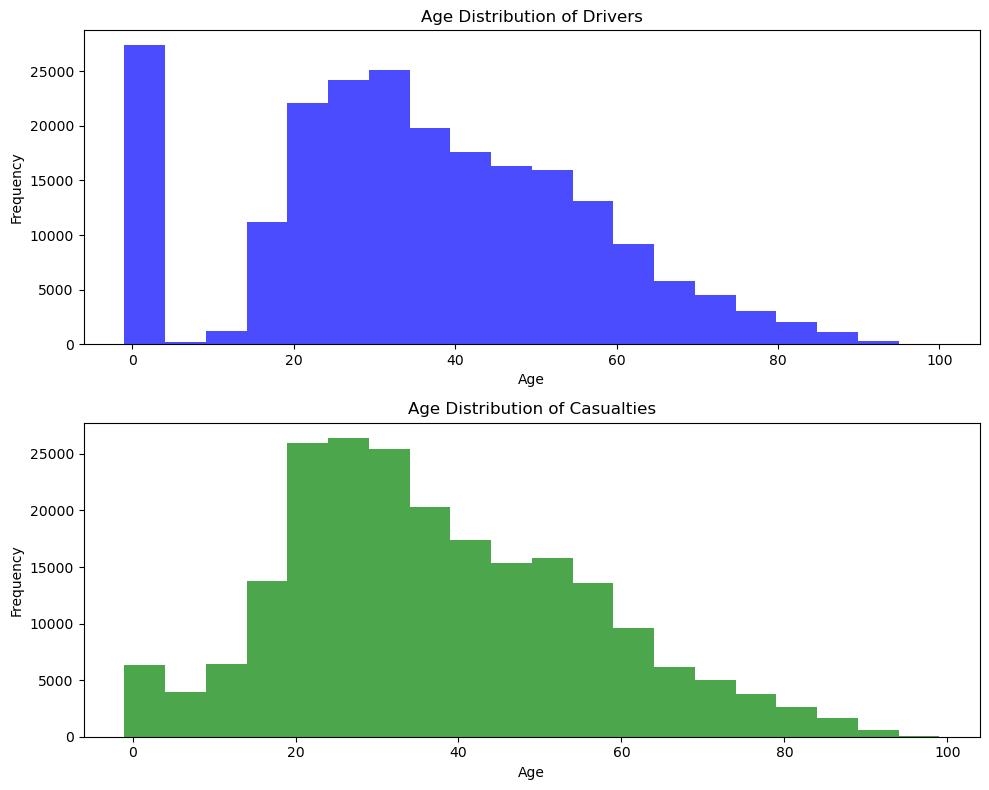

In [32]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the age distribution of drivers
axes[0].hist(joined_df['age_of_driver'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Age Distribution of Drivers')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the age distribution of casualties
axes[1].hist(joined_df['age_of_casualty'], bins=20, color='green', alpha=0.7)
axes[1].set_title('Age Distribution of Casualties')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


**Fill the underage drivers in driver_age and missing values in the age_of_casualty columns with the median**

In [ ]:
joined_df['road_surface_conditions'].replace(-1, np.nan, inplace=True)

In [51]:
# Calculate the overall median age of drivers who are of legal driving age (17 and above).
median_age = joined_df[joined_df['age_of_driver'] >17]['age_of_driver'].median()
print(median_age)
# For each underage driver (age <= 16), replace with the overall median age of drivers above 16
underage_driver_indices = joined_df[joined_df['age_of_driver'] < 17].index
joined_df.loc[underage_driver_indices, 'age_of_driver'] = median_age


38.0


In [60]:
# Calculate the overall median age of casualty
median_casualty_age = joined_df[joined_df['age_of_casualty'] > 17]['age_of_casualty'].median()
print(median_casualty_age)
# For each  missing casualty age (age <= 16), replace with the overall median age of casualties below 17
underage_casualty_indices = joined_df[joined_df['age_of_casualty'] <= 16].index
joined_df.loc[underage_casualty_indices, 'age_of_casualty'] = median_casualty_age


37.0


**Speed Limit**

In [35]:
#Calculate the average speed limit for each vehicle type
average_capacity_by_vehicle = joined_df.groupby('vehicle_type')['engine_capacity_cc'].mean()

# For each missing speed limit value, identify the corresponding vehicle type
missing_engine_capcty_df = joined_df[joined_df['engine_capacity_cc'] == -1]
missing_engine_vehicle_types = missing_engine_capcty_df['vehicle_type']

#  Replace the missing speed limit value with the average speed limit of the corresponding vehicle type
for vehicle_type in missing_engine_vehicle_types.unique():
    average_capacity = average_capacity_by_vehicle.get(vehicle_type, np.nan)
    joined_df.loc[(joined_df['engine_capacity_cc'] == -1) & (joined_df['vehicle_type'] == vehicle_type), 'engine_capacity_cc'] = average_speed

**Sex of Driver and Casualty**

In [36]:
# Calculate the median values for sex_of_driver and sex_of_casualty
# Define mappings for sex of driver
sex_mapping = {1: 'male', 2: 'female', 3: 'unknown', -1: 'missing'}
# Map the numerical values to sex categories for drivers
joined_df['sex_of_driver'] = joined_df['sex_of_driver'].map(sex_mapping)

# Define mappings for sex of casualty
sex_mapping = {1: 'male', 2: 'female', 3: 'unknown', -1: 'missing'}
# Map the numerical values to sex categories for drivers
joined_df['sex_of_casualty'] = joined_df['sex_of_casualty'].map(sex_mapping)

# Replace 'unknown' and 'missing' values with the mode
mode_sex_driver = joined_df['sex_of_driver'].mode()[0]
mode_sex_casualty = joined_df['sex_of_casualty'].mode()[0]

joined_df['sex_of_driver'] = joined_df['sex_of_driver'].replace({'unknown': mode_sex_driver, 'missing': mode_sex_driver})
joined_df['sex_of_casualty'] = joined_df['sex_of_casualty'].replace({'unknown': mode_sex_casualty, 'missing': mode_sex_casualty})


In [37]:
joined_df['sex_of_casualty']

0           male
1         female
2         female
3           male
4           male
           ...  
220430      male
220431      male
220432      male
220433      male
220434      male
Name: sex_of_casualty, Length: 220435, dtype: object

In [38]:
joined_df['sex_of_driver']

0         female
1           male
2           male
3           male
4           male
           ...  
220430      male
220431      male
220432    female
220433      male
220434      male
Name: sex_of_driver, Length: 220435, dtype: object

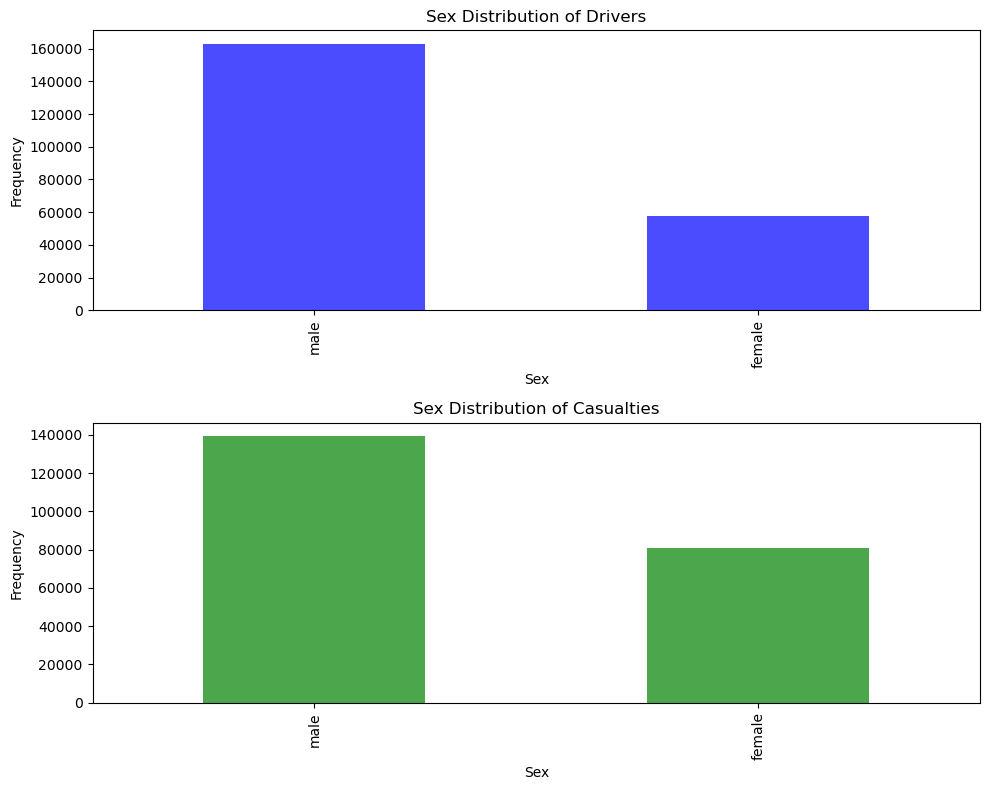

In [39]:
# Plot the distributions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the sex distribution of drivers
joined_df['sex_of_driver'].value_counts().plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title('Sex Distribution of Drivers')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Frequency')

# Plot the sex distribution of casualties
joined_df['sex_of_casualty'].value_counts().plot(kind='bar', ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Sex Distribution of Casualties')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [40]:
joined_df[relevant_columns].eq(-1).sum()

day_of_week                     0
time                            0
vehicle_type                    0
casualty_class                  0
accident_severity               0
weather_conditions              0
road_surface_conditions         0
light_conditions                0
junction_detail                 0
urban_or_rural_area             0
local_authority_ons_district    0
casualty_severity               0
speed_limit                     0
age_of_driver                   0
engine_capacity_cc              0
road_type                       0
sex_of_driver                   0
sex_of_casualty                 0
age_of_casualty                 0
dtype: int64

In [ ]:
joined_df[relevant_columns].columns

# Are there significant hours of the day, and days of the week, on which accidents occur?

In [44]:
day_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
# Map the numerical values in the 'day_of_week' column to day names
joined_df['day_of_week'] = joined_df['day_of_week'].map(day_mapping)
# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



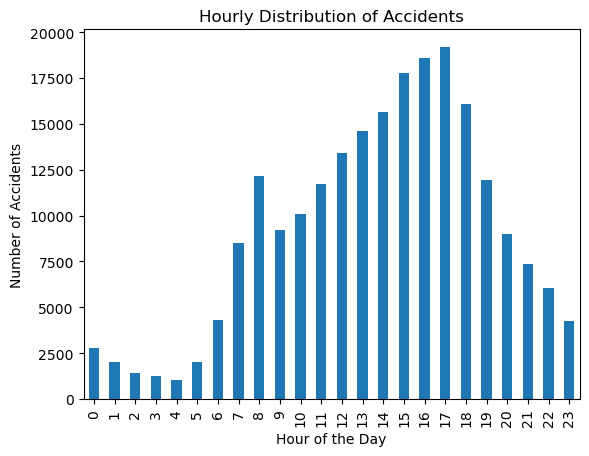

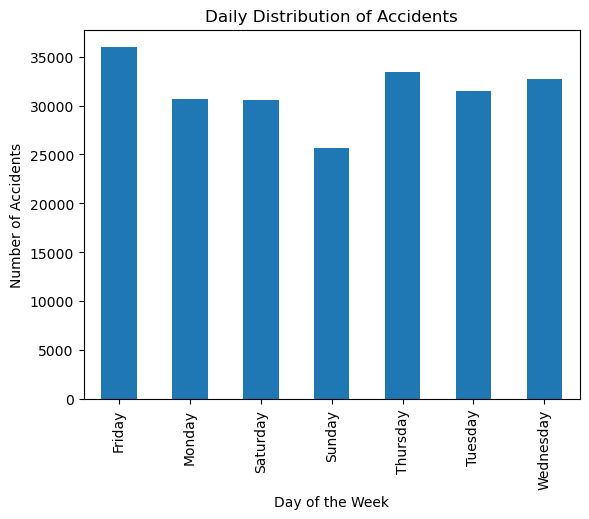

In [45]:
# Hourly Analysis
hourly_accidents = joined_df.groupby(joined_df['time'].dt.hour).size()
hourly_accidents.plot(kind='bar')
plt.title('Hourly Distribution of Accidents')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()

# Daily Analysis
daily_accidents = joined_df.groupby(joined_df['day_of_week']).size()
daily_accidents.plot(kind='bar')
plt.title('Daily Distribution of Accidents')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.show()

# For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

In [46]:
#find the unique values in vehicle_type column
vehicle_type=joined_df['vehicle_type']
vehicle_type.unique()

array([ 9,  8,  3,  2, 11,  1, 90, 19,  4,  5, 21, 97, 20, 98, 10, 17, 23,
       22, 18, 16], dtype=int64)

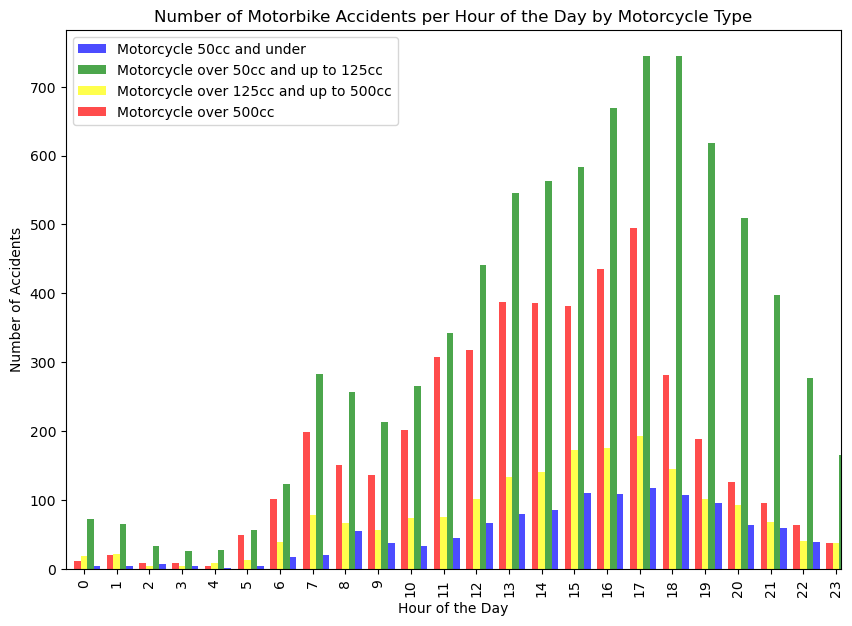

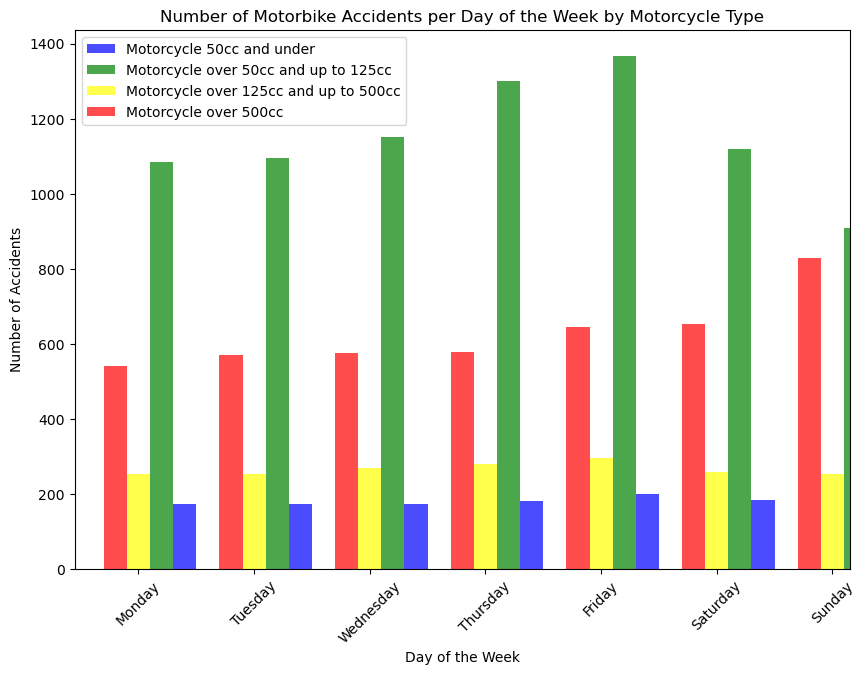

In [79]:
# Define motorcycle categories
motorcycle_categories = {
    'Motorcycle 50cc and under': '2',
    'Motorcycle over 50cc and up to 125cc': '3',
    'Motorcycle over 125cc and up to 500cc': '4',
    'Motorcycle over 500cc': '5'
}

# Define colors for each category
colors = ['blue', 'green', 'yellow', 'red']

# Plot accidents per hour of the day
plt.figure(figsize=(10, 7))
for (category, code), color in zip(motorcycle_categories.items(), colors):
    # Filter data for the specific motorcycle type
    filtered_data = joined_df[joined_df['vehicle_type'] == code]
    
    # Group by hour of the day and count accidents
    accidents_per_hour = filtered_data.groupby(filtered_data['time'].dt.hour).size().reindex(range(24), fill_value=0)
    
    # Plot accidents per hour of the day
    accidents_per_hour.plot(kind='bar', color=color, alpha=0.7, position=list(motorcycle_categories.values()).index(code) - 1.5, width=0.2)

plt.title('Number of Motorbike Accidents per Hour of the Day by Motorcycle Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(range(24))
plt.legend(motorcycle_categories.keys())
plt.show()


# Plot accidents per day of the week
plt.figure(figsize=(10, 7))
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for (category, code), color in zip(motorcycle_categories.items(), colors):
    # Filter data for the specific motorcycle type
    filtered_data = joined_df[joined_df['vehicle_type'] == code]
    
    # Group by day of the week and count accidents
    accidents_per_day = filtered_data['day_of_week'].value_counts().reindex(day_labels, fill_value=0)
    
    # Plot accidents per day of the week
    accidents_per_day.plot(kind='bar', color=color, alpha=0.7, position=list(motorcycle_categories.values()).index(code) - 1.5, width=0.2)

plt.title('Number of Motorbike Accidents per Day of the Week by Motorcycle Type')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(motorcycle_categories.keys())
plt.show()

# For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

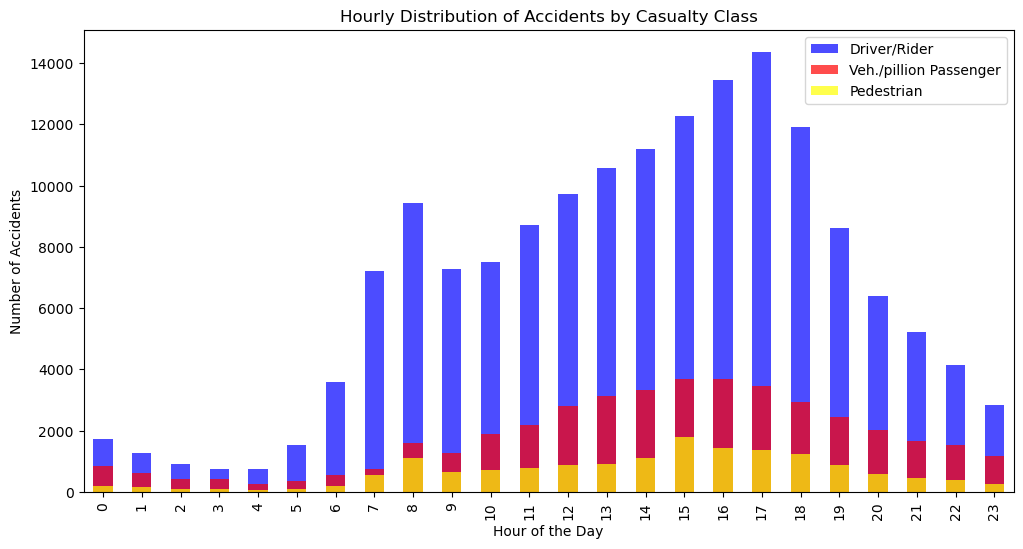

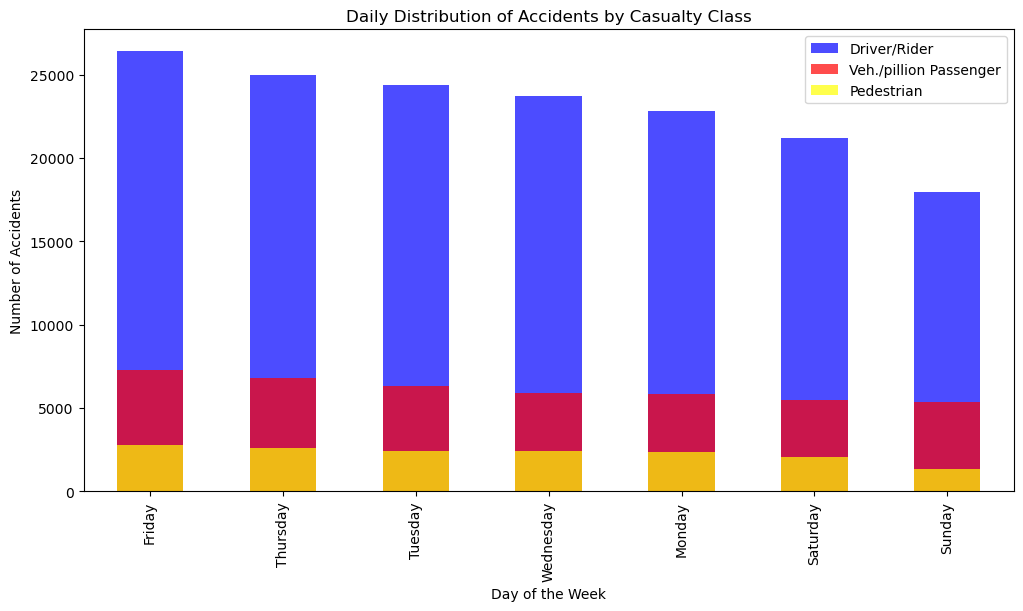

In [78]:
# Define casualty class mapping
casualty_class_mapping = {
    'Driver/Rider': 1,
    'Veh./pillion Passenger': 2,
    'Pedestrian': 3
}

# Define vibrant colors for the plots
colors = ['blue', 'red', 'yellow']

# Initialize lists to store data for plotting
hourly_distributions = []
daily_distributions = []

# Iterate over each casualty class
for casualty_class, code in casualty_class_mapping.items():
    # Filter the dataset to include only accidents involving the current casualty class
    casualty_df = joined_df[joined_df['casualty_class'] == code]
    
    # Check if the filtered DataFrame is not empty
    if not casualty_df.empty:
        # Hourly Analysis
        hourly_accidents = casualty_df.groupby(casualty_df['time'].dt.hour).size()
        hourly_distributions.append(hourly_accidents)

        # Daily Analysis
        daily_accidents = casualty_df['day_of_week'].value_counts()
        daily_distributions.append(daily_accidents)

# Plot hourly distributions
if hourly_distributions:
    plt.figure(figsize=(12, 6))
    for i, (hourly_distribution, casualty_class) in enumerate(zip(hourly_distributions, casualty_class_mapping.keys())):
        hourly_distribution.plot(kind='bar', alpha=0.7, color=colors[i], label=casualty_class)
    plt.title('Hourly Distribution of Accidents by Casualty Class')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.show()
else:
    print("No hourly data available for any casualty class.")

# Plot daily distributions
if daily_distributions:
    plt.figure(figsize=(12, 6))
    for i, (daily_distribution, casualty_class) in enumerate(zip(daily_distributions, casualty_class_mapping.keys())):
        daily_distribution.plot(kind='bar', alpha=0.7, color=colors[i], label=casualty_class)
    plt.title('Daily Distribution of Accidents by Casualty Class')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.show()
else:
    print("No daily data available for any casualty class.")


# Using the apriori algorithm, explore the impact of selected variables on accident severity.  

In [54]:
#apply onehot encoding to accident severity column
a_severity=pd.get_dummies(joined_df.accident_severity, prefix="severity")
a_severity

severity_1  severity_2  severity_3
0                0           0           1
1                0           0           1
2                0           0           1
3                0           0           1
4                0           1           0
...            ...         ...         ...
220430           0           1           0
220431           0           1           0
220432           0           0           1
220433           0           0           1
220434           0           0           1

[220435 rows x 3 columns]

In [84]:
#select variables
selected_variables = ['accident_severity','weather_conditions', 'road_surface_conditions', 
                       'light_conditions', 'road_type', 'speed_limit', 'junction_detail', 
                       'urban_or_rural_area', 'number_of_vehicles', 'number_of_casualties', 
                       'day_of_week']
sel_var = joined_df[selected_variables]

In [85]:
#find the unique values and their frequency in the columns accident severity, speed limit, weather condition
unique_counts=joined_df[selected_variables].nunique()
print("Unique Values \n")
print (unique_counts, end='\n\n')
print("Possible Values \n")
for column in selected_variables:
    print (f'{column}:',joined_df[column].unique())

Unique Values 

accident_severity           3
weather_conditions          9
road_surface_conditions     6
light_conditions            5
road_type                   6
speed_limit                12
junction_detail            10
urban_or_rural_area         3
number_of_vehicles         13
number_of_casualties       16
day_of_week                 7
dtype: int64

Possible Values 

accident_severity: [3 2 1]
weather_conditions: [9. 1. 8. 7. 2. 4. 5. 3. 6.]
road_surface_conditions: [9. 1. 2. 5. 4. 3.]
light_conditions: [1. 4. 5. 7. 6.]
road_type: [6 2 3 7 1 9]
speed_limit: [20. 30. 40. 50. 60. 70. 39. 32. 41. 53. 31. 35.]
junction_detail: [ 0  9  3  6  1 99  7  8  2  5]
urban_or_rural_area: [1 2 3]
number_of_vehicles: [ 1  2  3  4  8  6  7  5  9 10 11 13 12]
number_of_casualties: [ 1  2  4  3  6  5  9 11  7  8 10 17 41 13 12 19]
day_of_week: ['Tuesday' 'Monday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


In [86]:
# Apply one-hot encoding to each selected variable
encoded_df = pd.get_dummies(accident_df[selected_variables], columns=selected_variables, prefix=selected_variables)

In [87]:
encoded_df

accident_severity_1  accident_severity_2  accident_severity_3  \
0                        0                    0                    1   
1                        0                    0                    1   
2                        0                    0                    1   
3                        0                    1                    0   
4                        0                    0                    1   
...                    ...                  ...                  ...   
91194                    0                    1                    0   
91195                    0                    0                    1   
91196                    0                    1                    0   
91197                    0                    0                    1   
91198                    0                    0                    1   

       weather_conditions_-1  weather_conditions_1  weather_conditions_2  \
0                          0                     0                     0   
1                          0                     1                     0   
2                          0                     1                     0   
3                          0                     1                     0   
4                          0                     1                     0   
...                      ...                   ...                   ...   
91194                      0                     1                     0   
91195                      0                     1                     0   
91196                      0                     1                     0   
91197                      0                     1                     0   
91198                      0                     1                     0   

       weather_conditions_3  weather_conditions_4  weather_conditions_5  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
91194                     0                     0                     0   
91195                     0                     0                     0   
91196                     0                     0                     0   
91197                     0                     0                     0   
91198                     0                     0                     0   

       weather_conditions_6  ...  number_of_casualties_17  \
0                         0  ...                        0   
1                         0  ...                        0   
2                         0  ...                        0   
3                         0  ...                        0   
4                         0  ...                        0   
...                     ...  ...                      ...   
91194                     0  ...                        0   
91195                     0  ...                        0   
91196                     0  ...                        0   
91197                     0  ...                        0   
91198                     0  ...                        0   

       number_of_casualties_19  number_of_casualties_41  day_of_week_1  \
0                            0                        0              0   
1                            0                        0              0   
2                            0                        0              0   
3                            0                        0              0   
4                            0                        0              0   
...                        ...                      ...            ...   
91194                        0                        0              0   
911

In [89]:
# Generate frequent itemsets
freq_item_sets = apriori(encoded_df, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(freq_item_sets, metric='lift', min_threshold=0.5)

# Filter rules with minimum support of 0.3 and minimum confidence of 0.7
filtered_rules = rules[(rules['support'] >= 0.3) & (rules['confidence'] >= 0.7)]

# Filter rules where the consequent is accident_severity
sorted_filtered_rules = filtered_rules[filtered_rules['consequents'].apply(lambda x: any('accident_severity_' in item for item in x))]

# Sort the filtered rules by lift
sorted_filtered_rules = sorted_filtered_rules.sort_values(by='lift', ascending=False)

# Set display options to show all columns without truncation
pd.set_option('display.max_colwidth', None)

# Print the top 5 filtered rules
N = 5
top_filtered_rules = sorted_filtered_rules.head(N)
top_filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


C:\Users\User\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


antecedents  \
786                            (road_surface_conditions_1, number_of_vehicles_2)   
775                           (road_surface_conditions_1, urban_or_rural_area_1)   
2947  (road_surface_conditions_1, urban_or_rural_area_1, number_of_casualties_1)   
758                                  (speed_limit_30, road_surface_conditions_1)   
2676     (light_conditions_1, road_surface_conditions_1, number_of_casualties_1)   

                                      consequents   support  confidence  \
786   (accident_severity_3, weather_conditions_1)  0.343447    0.764865   
775   (accident_severity_3, weather_conditions_1)  0.364456    0.756028   
2947  (accident_severity_3, weather_conditions_1)  0.310968    0.755260   
758   (accident_severity_3, weather_conditions_1)  0.306012    0.751184   
2676  (accident_severity_3, weather_conditions_1)  0.328699    0.743625   

          lift  
786   1.268041  
775   1.253390  
2947  1.252116  
758   1.245360  
2676  1.232827

# Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region? 

In [60]:
# Select accidents within the Humberside region (police_force = 16)
humberside_accidents = joined_df[joined_df['police_force'] == 16]

# Extract latitude and longitude
X = humberside_accidents[['latitude', 'longitude']].values

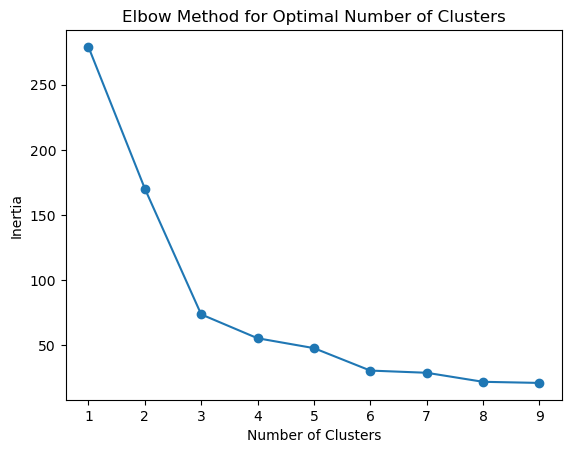

In [61]:
# Define the range of clusters to test

inertia = []

# Compute inertia for different numbers of clusters
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 10))
plt.show()

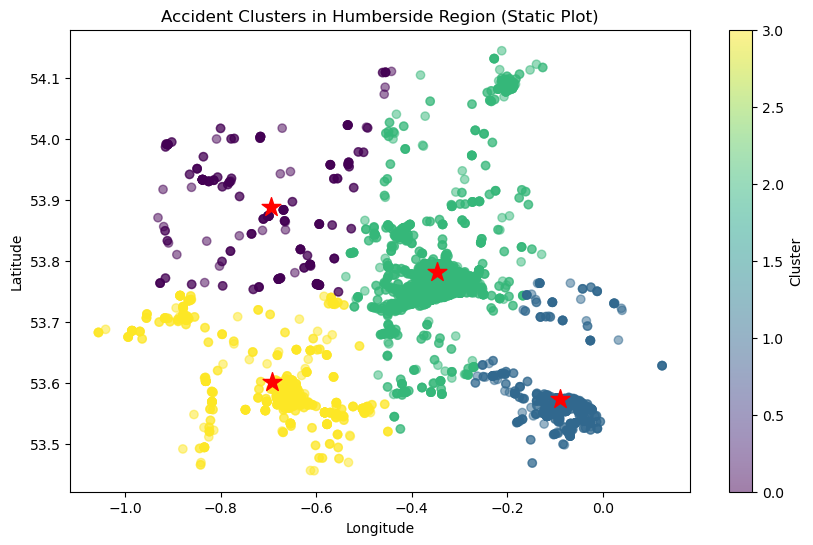

In [62]:
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

# Select accidents within the Humberside region (police_force = 16)
humberside_accidents = joined_df[joined_df['police_force'] == 16]

# Extract latitude and longitude
X = humberside_accidents[['latitude', 'longitude']].values

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
clusters = kmeans.predict(X)

# visualise clusters
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', alpha=0.5)

# Plot centroids
for cluster in set(clusters):
    centroid = kmeans.cluster_centers_[cluster]
    ax.scatter(centroid[1], centroid[0], marker='*', s=200, color='red')

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Accident Clusters in Humberside Region (Static Plot)')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# Interactive map 
m = folium.Map(location=[humberside_accidents['latitude'].mean(), humberside_accidents['longitude'].mean()], zoom_start=10)

# Add markers for each accident location, colored by cluster
marker_cluster = MarkerCluster().add_to(m)
for point, cluster in zip(X, clusters):
    folium.CircleMarker(location=(point[0], point[1]),
                        radius=3,
                        fill=True,
                        color=plt.cm.viridis(cluster / (len(set(clusters)) - 1)),
                        fill_opacity=0.5,
                        popup=f"Cluster: {cluster}").add_to(marker_cluster)

# Add centroids as larger markers
for cluster in set(clusters):
    centroid = kmeans.cluster_centers_[cluster]
    folium.CircleMarker(location=(centroid[0], centroid[1]),
                        radius=10,
                        color='red',
                        fill=True,
                        fill_opacity=1,
                        popup=f"Cluster centroid").add_to(m)

# Display the interactive map
m

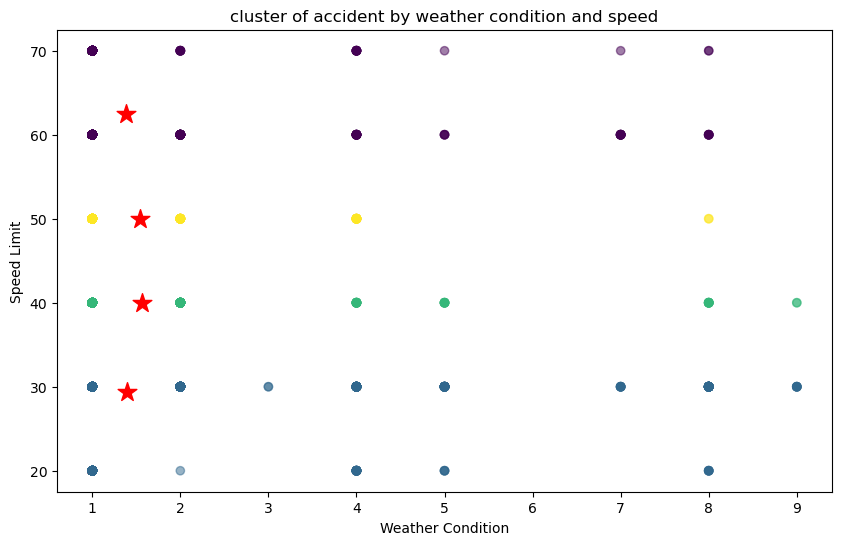

In [63]:
# Extract latitude and longitude
X = humberside_accidents[['speed_limit', 'weather_conditions']].values

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
clusters = kmeans.predict(X)

# visualise clusters
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', alpha=0.5)

# Plot centroids
for cluster in set(clusters):
    centroid = kmeans.cluster_centers_[cluster]
    ax.scatter(centroid[1], centroid[0], marker='*', s=200, color='red')

# Set axis labels and title
ax.set_xlabel('Weather Condition')
ax.set_ylabel('Speed Limit')
ax.set_title('cluster of accident by weather condition and speed')

plt.show()


# Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data? 

In [95]:
# detect outliers using the IQR method
def detect_outliers_iqr(df, columns):
    outliers = pd.DataFrame()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        is_outlier = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
        outliers = pd.concat([outliers, df[is_outlier]], axis=0)
    return outliers.drop_duplicates()

# List of numerical columns to check for outliers
numerical_columns = ['number_of_vehicles', 'number_of_casualties', 'age_of_driver', 'age_of_vehicle','age_of_casualty','speed_limit']

# Detect outliers in the entire dataset
iqr_outliers = detect_outliers_iqr(joined_df, numerical_columns)
print("Outliers detected using IQR method:")
print(iqr_outliers)


Outliers detected using IQR method:
       accident_index  accident_year accident_reference  \
0       2020010219808           2020          010219808   
1       2020010220496           2020          010220496   
2       2020010220496           2020          010220496   
3       2020010228005           2020          010228005   
4       2020010228006           2020          010228006   
...               ...            ...                ...   
219343  2020991000461           2020          991000461   
219674  2020991004522           2020          991004522   
220254  2020991010939           2020          991010939   
220255  2020991010939           2020          991010939   
220389  2020991016435           2020          991016435   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    529337.0                176237.0  -0.139253  51.470327   
2                 

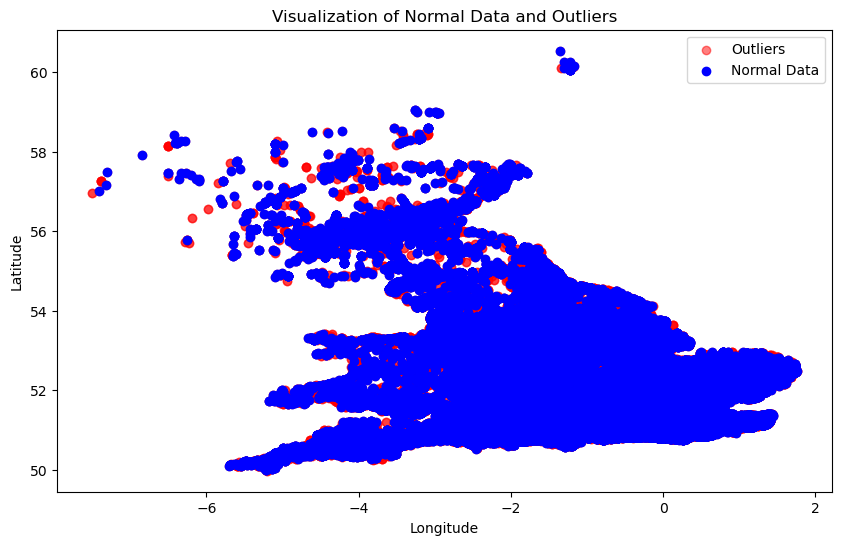

In [96]:

# Plot both normal data and outliers
plt.figure(figsize=(10, 6))
plt.scatter(joined_df['longitude'], joined_df['latitude'], color='red', alpha=0.5, label='Outliers')
plt.scatter(iqr_outliers['longitude'], iqr_outliers['latitude'], color='blue', label='Normal Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of Normal Data and Outliers')
plt.legend()
plt.show()


# develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

In [99]:
# Extract hour from the 'time' column
joined_df['hour'] = pd.to_datetime(joined_df['time']).dt.hour

# Drop the original 'time' column
joined_df.drop('time', axis=1, inplace=True)

In [106]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Define features and target variable
features = joined_df[['day_of_week', 'vehicle_type', 'casualty_class','journey_purpose_of_driver',
                    'weather_conditions', 'road_surface_conditions', 'light_conditions', 'vehicle_left_hand_drive',
                    'junction_detail', 'urban_or_rural_area', 'local_authority_ons_district', 'first_point_of_impact',
                    'road_type', 'speed_limit', 'sex_of_driver', 'sex_of_casualty','skidding_and_overturning', 'hour',
                    'age_of_driver', 'engine_capacity_cc', 'age_of_casualty']]
target = joined_df['accident_severity']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object']).columns
numerical_cols = features.select_dtypes(include=['number']).columns

# Define preprocessing steps for categorical and numerical columns
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = SimpleImputer(strategy='median')

# Apply preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_cols),
        ('num', numerical_preprocessor, numerical_cols)
    ])

# Fit and transform the data using the preprocessor
features_preprocessed = preprocessor.fit_transform(features)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_preprocessed, target, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)


Accuracy: 0.8376618957969469

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.36      0.53       823
           2       0.92      0.29      0.44      9082
           3       0.83      0.99      0.91     34182

    accuracy                           0.84     44087
   macro avg       0.92      0.55      0.63     44087
weighted avg       0.85      0.84      0.80     44087



**Apply Smote to address class imbalancing**

In [107]:
from imblearn.over_sampling import SMOTE
# Define features and target variable
features = joined_df[['day_of_week', 'vehicle_type', 'casualty_class', 'journey_purpose_of_driver',
                      'weather_conditions', 'road_surface_conditions', 'light_conditions', 'vehicle_left_hand_drive',
                      'junction_detail', 'urban_or_rural_area', 'local_authority_ons_district', 'first_point_of_impact',
                      'road_type', 'speed_limit', 'sex_of_driver', 'sex_of_casualty', 'skidding_and_overturning', 'hour',
                      'age_of_driver', 'engine_capacity_cc', 'age_of_casualty']]
target = joined_df['accident_severity']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object']).columns
numerical_cols = features.select_dtypes(include=['number']).columns

# Define preprocessing steps for categorical and numerical columns
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = SimpleImputer(strategy='median')

# Apply preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_cols),
        ('num', numerical_preprocessor, numerical_cols)
    ])

# Fit and transform the data using the preprocessor
features_preprocessed = preprocessor.fit_transform(features)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features_preprocessed, target)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

Accuracy: 0.9343356738568066

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99     34173
           2       0.99      0.83      0.90     34480
           3       0.85      0.99      0.91     34173

    accuracy                           0.93    102826
   macro avg       0.94      0.93      0.93    102826
weighted avg       0.94      0.93      0.93    102826

